#### Loading Datasets

In [2]:
import pandas as pd
df=pd.read_csv('amazon_product_return.csv')
df.head()

,order_id,asin,category,order_date,price,size_category,will_return,shipped_month,return_date,return_days,return_reason,return_month,within_3_months
0,1,B39620245,Home & Kitchen,2022-01-01,48.13,M,0,9,2022-01-10,9.0,Not as Expected,1,1
1,2,B39033121,Fashion,2022-01-02,59.71,M,1,4,2022-01-24,23.0,Damaged,1,1
2,3,B10914610,Sports,2022-01-03,44.50,S,0,11,2022-01-04,3.0,Damaged,1,1
3,4,B82160482,Home & Kitchen,2022-01-04,86.99,S,0,7,2022-02-11,41.0,Not as Expected,2,1
4,5,B43565170,Sports,2022-01-05,66.96,S,0,5,2022-01-14,13.0,Damaged,1,1


### 1. Understanding Exponential Distribution

The exponential distribution models the time between events in a Poisson process, where events occur continuously and independently at a contant rate.

- lambda(parameter) : Represent the average no of events per unit time.
- Mean: 1/ lambda
- Variance: 1/ lambda^square

##### Identifying Lambda(mean(return_days)) column From data sets

The Exponential distribution is often used when we want to model how long we have to wait for something to happen — like a customer returning a product.

It's especially useful when:

1. Returns happen at a steady average rate — meaning, over time, returns happen randomly but at a fairly consistent pace.

2. The chance of a return happening tomorrow doesn’t depend on how long it’s already been since the order — this is called the memoryless property. In simple terms, whether it's been 2 days or 10 days since the purchase, the odds of the item being returned tomorrow stay the same.

In [207]:
import numpy as np

# Filter churned customers
return_days= df['return_days']

# Estimate lambda
lambda_forall = 1 / np.mean(return_days)
print(f"Estimated returnd days (lambdha): {lambda_forall:.6f} per day")

Estimated returnd days (lambdha): 0.034302 per day


### 2. Kolmogorov-Smirnov (KS) Test 

The Kolmogorov-Smirnov (KS) test is a statistical test that compares a sample distribution to a theoretical distribution (like exponential, normal, etc.) to check how well they match.

In [209]:
# Kolmogorov-Smirnov (KS) Test
from scipy.stats import expon, kstest

threshold_p=0.05

ks_statistic, p_value = kstest(return_days, 'expon', args=(0, 1/lambda_forall))


if p_value > threshold_p:
    print("The data appears to follow an exponential distribution (fail to reject H0).")
else:
    print("The data does not appear to follow an exponential distribution (reject H0).")
    
print("Built-in KS Statistic:", ks_statistic)
print("P-value:", p_value)

The data appears to follow an exponential distribution (fail to reject H0).
Built-in KS Statistic: 0.02862552956506048
P-value: 0.37846408486876915


### 3. Exponential Probability Density Functions(PDF)

- The exponential gives the probability density of the random variable at a specific point x. It tells us how dense the probability is around a particular value of x.
- The PDF gives the density of occurence at a specific point x. It is a probability but measure of how concentrated the probability is around.
- For probability calculation require integrating the pdf over an interval[a,b].

In [110]:
from scipy.stats import expon

exp_pdf=expon.pdf(return_days,scale=1/lambda_forall)
#print(f'PDF values: {[f"{val:.4f}" for val in exp_pdf]}')


#### PDF and PMF

- ##### PDF for Continuous data
- Exponential distribution is a continuous distribution, we cannot directly assign a probability to a single point(like p(X=x)).
- Instead, we use the pdf to define a density function and probability are obtain by integrating over a range of value.

- ##### PMF for discrete data
- Probability Mass Function is used for discrete random variable, where the outcomes are countable and distinct(e.g. no. of arrivals, no. of failures)
- In contrast, the exponential distribution can take on any positive real values(e.g. 1.2, 3.5,0.89), not just integer counts.

  

In [172]:
from scipy.integrate import quad

# Exponential PDF function
def exponential_pdf(x, lambd):
    return lambd * np.exp(-lambd * x)

#parameters
lambd= lambda_forall
interval=(29.5,30)

# Calculate probability over the interval using quad
# P(a<=x<=b) at interval[a,b]
pdf_prob_interval, _ = quad(exponential_pdf, interval[0], interval[1], args=(lambd,))
print(f"Probability over interval {interval}: {pdf_prob_interval:.4f}")

Probability over interval (29.5, 30): 0.0062


#### Interpretation

- Probability of product return of purchases between 29.5 days and 30 days is 0.62%

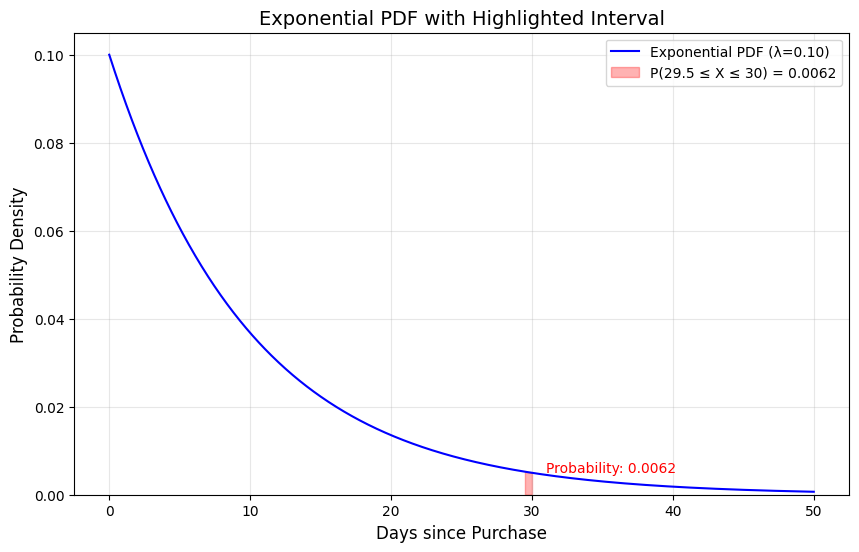

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import expon

# Exponential PDF function
def exponential_pdf(x, lambd):
    return lambd * np.exp(-lambd * x)

# Parameters
lambda_hat = 0.1  # Example rate parameter (replace with your actual value)
lambd = lambda_hat
interval = (29.5, 30)


# Visualization
x = np.linspace(0, 50, 1000)  # Adjust range as needed
pdf_values = expon.pdf(x, scale=1/lambd)  # Equivalent to exponential_pdf(x, lambd)

plt.figure(figsize=(10, 6))
plt.plot(x, pdf_values, label=f'Exponential PDF (λ={lambd:.2f})', color='blue')

# Highlight the interval
x_fill = np.linspace(interval[0], interval[1], 100)
plt.fill_between(x_fill, expon.pdf(x_fill, scale=1/lambd), color='red', alpha=0.3, 
                 label=f'P({interval[0]} ≤ X ≤ {interval[1]}) = {probability:.4f}')

# Annotate the probability
plt.text(interval[1]+1, 0.005, f'Probability: {probability:.4f}', fontsize=10, color='red')

# Formatting
plt.xlabel('Days since Purchase', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('Exponential PDF with Highlighted Interval', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.ylim(0, max(pdf_values)*1.05)  # Add slight margin at top
plt.show()

### 4. Exponential Cumulative Distributions Functions
- The CDF gives the accumulated probability up to a point x. It is the probability that the random variable is less than or equal to x i.e P(x<=k).
- For probability calculation can directly use the CDF at endpoint a and b.

In [141]:
#calculate probability product return less and equal at 30 days
# p(x<=30)
exp_cdf=expon.cdf(30,scale=1/lambda_forall)
print(f"Probability of return within 30 days: {exp_cdf}")

Probability of return within 30 days: 0.6426550130054031


Probability of return within 30 days: 0.6426550130054031


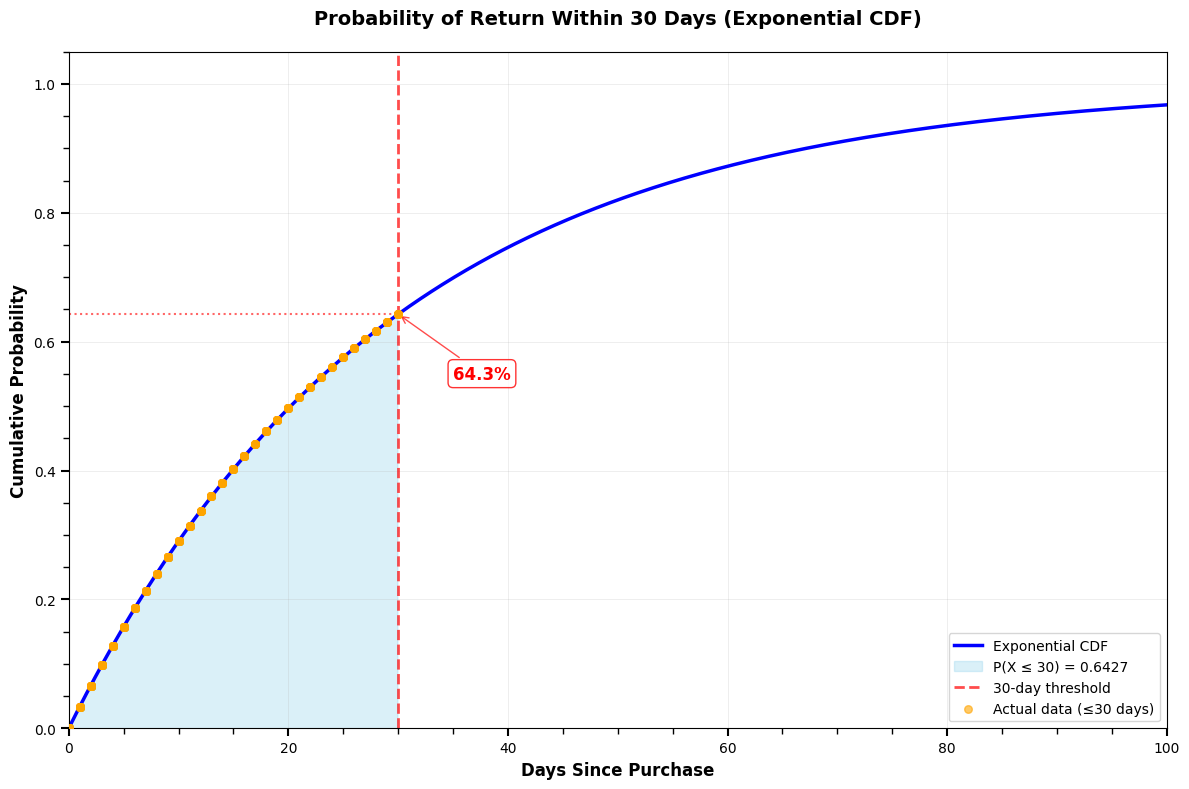

In [159]:

# Calculate probability product return less and equal at 30 days
# P(X <= 30)
exp_cdf = expon.cdf(30, scale=1/lambda_forall)
print(f"Probability of return within 30 days: {exp_cdf}")

# Calculate each CDF values for points less than or equal to 30 days
# Assuming return_days is your data array
exp_cdf_values = expon.cdf(return_days[return_days <= 30], scale=1/lambda_forall)

# Generate data for smooth CDF curve
x_range = np.linspace(0, 100, 1000)
cdf_curve = expon.cdf(x_range, scale=1/lambda_forall)

# Create the visualization
plt.figure(figsize=(12, 8))

# Plot the main CDF curve
plt.plot(x_range, cdf_curve, label='Exponential CDF', color='blue', linewidth=2.5)

# Highlight the area for P(X <= 30)
x_fill = x_range[x_range <= 30]
y_fill = cdf_curve[x_range <= 30]
plt.fill_between(x_fill, y_fill, alpha=0.3, color='skyblue', 
                 label=f'P(X ≤ 30) = {exp_cdf:.4f}')

# Add vertical line at 30 days
plt.axvline(x=30, color='red', linestyle='--', alpha=0.7, linewidth=2, 
            label='30-day threshold')

# Add horizontal line showing the probability level
plt.axhline(y=exp_cdf, color='red', linestyle=':', alpha=0.6, 
            xmax=0.3, linewidth=1.5)

# Plot actual data points (if available)
if 'return_days' in locals():
    # Plot CDF values for actual data points <= 30 days
    data_points_30 = return_days[return_days <= 30]
    cdf_data_30 = expon.cdf(data_points_30, scale=1/lambda_forall)
    
    plt.scatter(data_points_30, cdf_data_30, color='orange', alpha=0.6, 
                s=30, label='Actual data (≤30 days)', zorder=5)

# Annotations
plt.annotate(f'{exp_cdf*100:.1f}%', 
             xy=(30, exp_cdf), xytext=(35, exp_cdf-0.1),
             fontsize=12, color='red', weight='bold',
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", 
                      edgecolor="red", alpha=0.8))



# Formatting
plt.xlabel('Days Since Purchase', fontsize=12, weight='bold')
plt.ylabel('Cumulative Probability', fontsize=12, weight='bold')
plt.title('Probability of Return Within 30 Days (Exponential CDF)', 
          fontsize=14, weight='bold', pad=20)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.ylim(0, 1.05)
plt.xlim(0, 100)

# Add minor ticks for better readability
plt.gca().tick_params(which='major', length=6, width=1.5)
plt.gca().tick_params(which='minor', length=4, width=1)
plt.minorticks_on()

plt.tight_layout()
plt.savefig('exponential_cdf_30days.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()



### 5. Relationship Between PDF and CDF

Integrating the PDF over an interval is equivalent to taking the difference of CDF values at the endpoints. The CDF itself is the accumulated integral of pdf, so the area calculated through integration is the same as same as the area obtained using CDF subtractions.

- Integral of f(x) from a to b = CDF at b minus CDF at a




In [176]:
#retrive probability over the interval using quad as done above
# P(a<=x<=b) at interval[a,b]
print(f" PDF Probability over interval {interval}: {pdf_prob_interval:.4f}")

 PDF Probability over interval (29.5, 30): 0.0062


In [182]:
print(f"Probability of return within 30 days: {exp_cdf:.4f}")
exp_cdf_29_5=expon.cdf(29.5,scale=1/lambda_forall)
print(f"Probability of return within 20.9 days: {exp_cdf_29_5:.4f}")
#CDF at b minus CDF at a
prob_cdf_interval=abs(exp_cdf - exp_cdf_29_5)
print(f"CDF Probability over interval {interval}: {prob_cdf_interval:.4f}")

Probability of return within 30 days: 0.6427
Probability of return within 20.9 days: 0.6365
CDF Probability over interval (29.5, 30): 0.0062


In [188]:
#checking if they are approximatively equal or close enough 

import numpy as np

if np.isclose(pdf_prob_interval, prob_cdf_interval, rtol=1e-9):
    print('The integral of the PDF matches the CDF difference — they are mathematically equivalent.')
else:
    print('Minor numerical difference found — likely due to floating-point precision.')


The integral of the PDF matches the CDF difference — they are mathematically equivalent.


### 6.  Exponential Survial Function(SF)

- is a function that gives the probability that a random variable X exceed a certain value k.
- In the other word, it tells us the probability of Surviving beyond time k without the event occuring.
- Mathematically,
1. P(X <=k)= CDF
2. S(k)=P(X >= k) = 1 - P(X <= k)
3. Thus, S(k)= survival function beyond time k = 1 minus (CDF less or equal to k)

##### Example: the probability that a product will not be returned after 60 days

In [197]:
exp_sf_60=expon.sf(60 ,scale=1/lambda_forall)
print(f"the probability that a product will not be returned after 60 days: {exp_sf_60}")

the probability that a product will not be returned after 60 days: 0.12769543973016867


The probability that a product will not be returned after 60 days: 0.12769543973016867


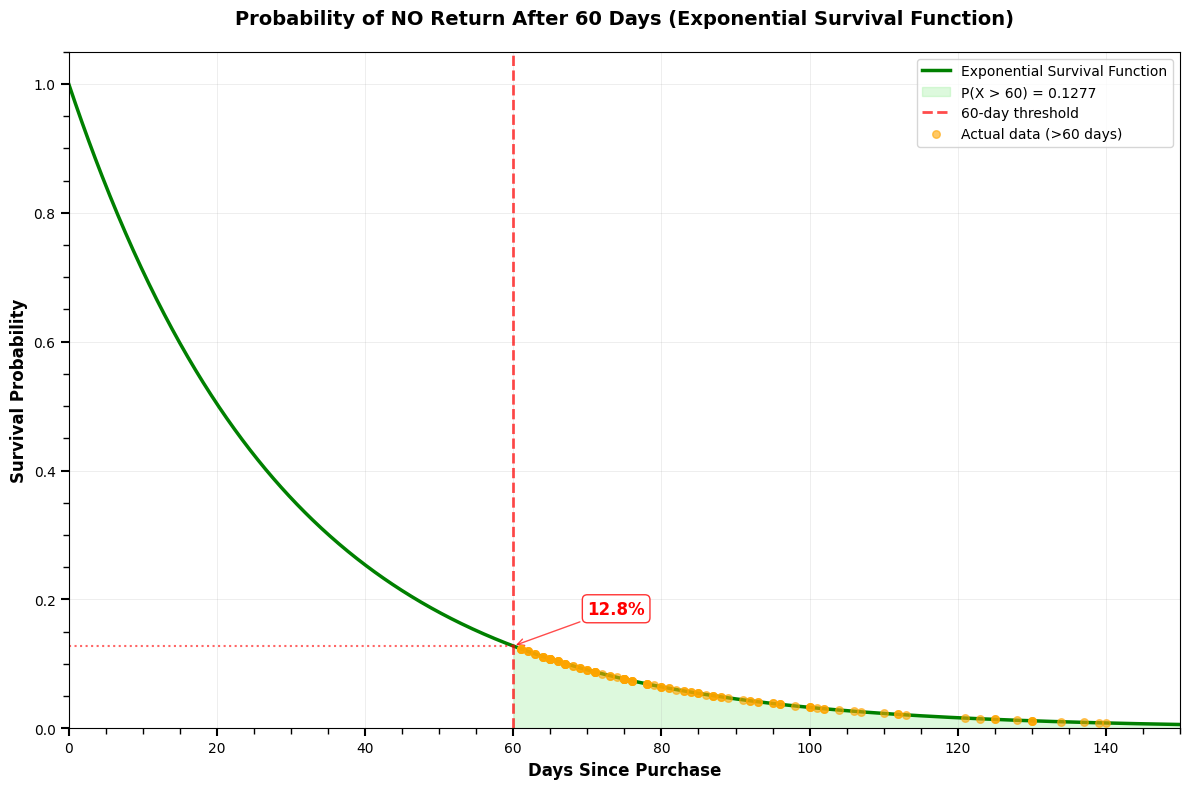


Relationship verification:
SF(60) = 0.1277
CDF(60) = 0.8723
SF(60) + CDF(60) = 1.0000 (should be 1.0)


In [203]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

# Calculate probability that a product will NOT be returned after 60 days
# P(X > 60) using survival function
exp_sf_60 = expon.sf(60, scale=1/lambda_forall)
print(f"The probability that a product will not be returned after 60 days: {exp_sf_60}")

# Calculate each SF values for points greater than 60 days
# Assuming return_days is your data array
exp_sf_values = expon.sf(return_days[return_days > 60], scale=1/lambda_forall)

# Generate data for smooth SF curve
x_range = np.linspace(0, 150, 1000)
sf_curve = expon.sf(x_range, scale=1/lambda_forall)

# Create the visualization
plt.figure(figsize=(12, 8))

# Plot the main SF curve
plt.plot(x_range, sf_curve, label='Exponential Survival Function', color='green', linewidth=2.5)

# Highlight the area for P(X > 60)
x_fill = x_range[x_range >= 60]
y_fill = sf_curve[x_range >= 60]
plt.fill_between(x_fill, y_fill, alpha=0.3, color='lightgreen', 
                 label=f'P(X > 60) = {exp_sf_60:.4f}')

# Add vertical line at 60 days
plt.axvline(x=60, color='red', linestyle='--', alpha=0.7, linewidth=2, 
            label='60-day threshold')

# Add horizontal line showing the probability level
plt.axhline(y=exp_sf_60, color='red', linestyle=':', alpha=0.6, 
            xmax=0.4, linewidth=1.5)

# Plot actual data points (if available)
if 'return_days' in locals():
    # Plot SF values for actual data points > 60 days
    data_points_60 = return_days[return_days > 60]
    sf_data_60 = expon.sf(data_points_60, scale=1/lambda_forall)
    
    plt.scatter(data_points_60, sf_data_60, color='orange', alpha=0.6, 
                s=30, label='Actual data (>60 days)', zorder=5)

# Annotations
plt.annotate(f'{exp_sf_60*100:.1f}%', 
             xy=(60, exp_sf_60), xytext=(70, exp_sf_60+0.05),
             fontsize=12, color='red', weight='bold',
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", 
                      edgecolor="red", alpha=0.8))


# Formatting
plt.xlabel('Days Since Purchase', fontsize=12, weight='bold')
plt.ylabel('Survival Probability', fontsize=12, weight='bold')
plt.title('Probability of NO Return After 60 Days (Exponential Survival Function)', 
          fontsize=14, weight='bold', pad=20)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.ylim(0, 1.05)
plt.xlim(0, 150)

# Add minor ticks for better readability
plt.gca().tick_params(which='major', length=6, width=1.5)
plt.gca().tick_params(which='minor', length=4, width=1)
plt.minorticks_on()

plt.tight_layout()
plt.savefig('exponential_sf_60days.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()



# Compare with CDF
exp_cdf_60 = expon.cdf(60, scale=1/lambda_forall)
print(f"\nRelationship verification:")
print(f"SF(60) = {exp_sf_60:.4f}")
print(f"CDF(60) = {exp_cdf_60:.4f}")
print(f"SF(60) + CDF(60) = {exp_sf_60 + exp_cdf_60:.4f} (should be 1.0)")

### 7. Exponential Percent Point Function(PPF)

- The PPF is the inverse of the CDF:
- PPF gives the smallest value of k such that the culmulative probability P(x<=k) reaches or exceeds a certain probability p.
- CDF tells you the cumulative probability up to k
- PPF tells you the smallest k such the cumulative probability exceeds or equals p.
- Example: the number of days within which 90% of products will be returned

In [222]:
# Calculate the number of days within which 90% of products will be returned
days_90_percent=expon.ppf(0.90,scale=1/lambda_forall)
print(f"Number of days within which 90% of products will be returned: {days_90_percent} days")

Number of days within which 90% of products will be returned: 67.12726321605543 days


Number of days within which 90% of products will be returned: 67.13 days


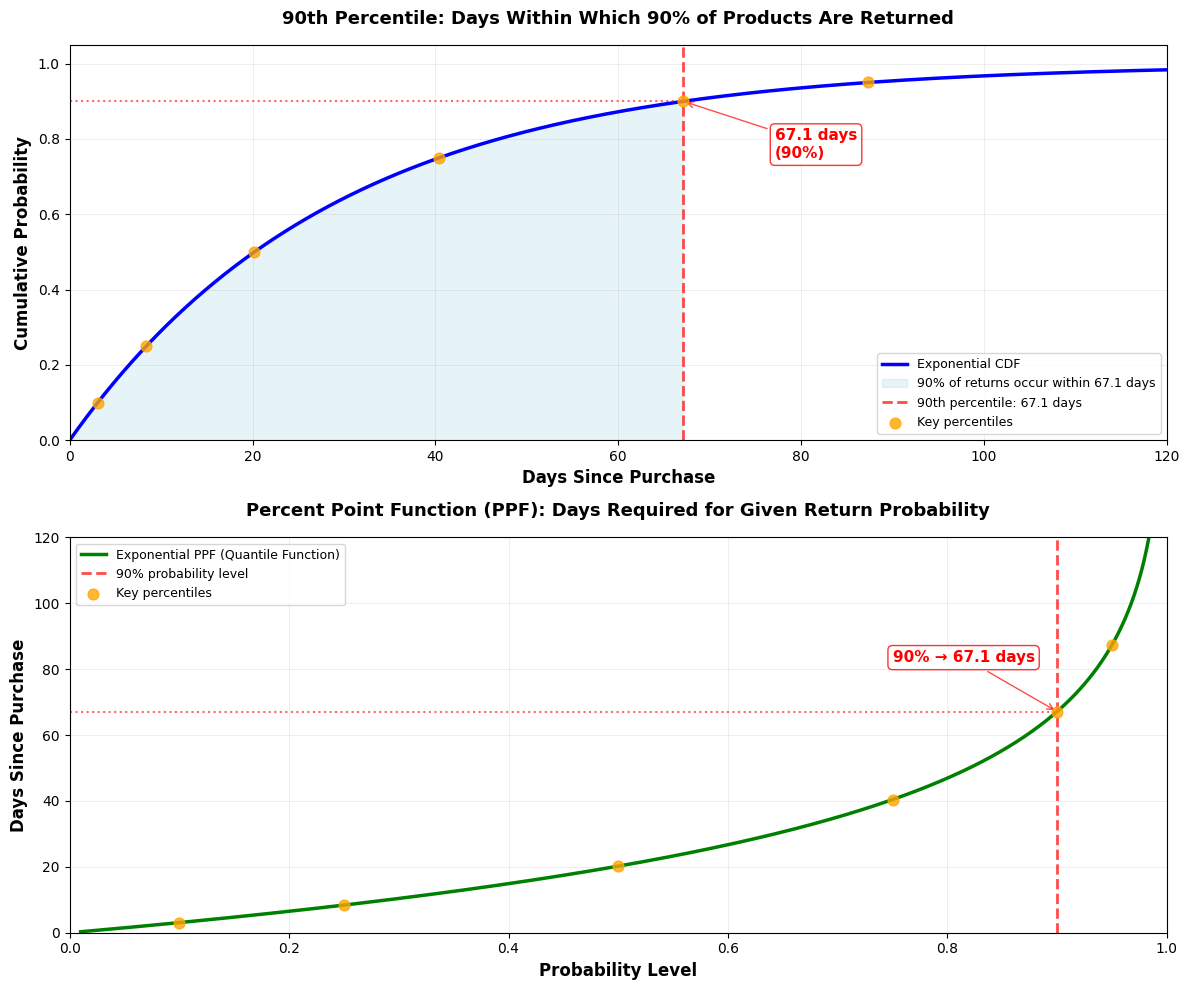


Key Percentiles Analysis:
10th percentile: 3.1 days (10% of products returned)
25th percentile: 8.4 days (25% of products returned)
50th (Median) percentile: 20.2 days (50% of products returned)
75th percentile: 40.4 days (75% of products returned)
90th percentile: 67.1 days (90% of products returned)
95th percentile: 87.3 days (95% of products returned)
99th percentile: 134.3 days (99% of products returned)

Business Insights:
• 50% of products will be returned within 20.2 days
• 90% of products will be returned within 67.1 days
• Only 10% of products will be returned after 67.1 days


In [226]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

# Calculate the number of days within which 90% of products will be returned
days_90_percent = expon.ppf(0.90, scale=1/lambda_forall)
print(f"Number of days within which 90% of products will be returned: {days_90_percent:.2f} days")

# Calculate PPF values for different probability levels
prob_levels = np.array([0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])
ppf_values = expon.ppf(prob_levels, scale=1/lambda_forall)

# Generate data for smooth CDF curve (for reference)
x_range = np.linspace(0, 120, 1000)
cdf_curve = expon.cdf(x_range, scale=1/lambda_forall)

# Create the visualization with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top subplot: CDF with PPF highlighted
ax1.plot(x_range, cdf_curve, label='Exponential CDF', color='blue', linewidth=2.5)

# Highlight the area for P(X <= days_90_percent) = 0.90
x_fill = x_range[x_range <= days_90_percent]
y_fill = cdf_curve[x_range <= days_90_percent]
ax1.fill_between(x_fill, y_fill, alpha=0.3, color='lightblue', 
                 label=f'90% of returns occur within {days_90_percent:.1f} days')

# Add vertical line at 90th percentile
ax1.axvline(x=days_90_percent, color='red', linestyle='--', alpha=0.7, linewidth=2, 
            label=f'90th percentile: {days_90_percent:.1f} days')

# Add horizontal line at 90% probability
ax1.axhline(y=0.90, color='red', linestyle=':', alpha=0.6, 
            xmax=days_90_percent/120, linewidth=1.5)

# Plot key percentile points
ax1.scatter(ppf_values, prob_levels, color='orange', alpha=0.8, 
            s=60, label='Key percentiles', zorder=5)

# Annotations for top subplot
ax1.annotate(f'{days_90_percent:.1f} days\n(90%)', 
             xy=(days_90_percent, 0.90), xytext=(days_90_percent+10, 0.75),
             fontsize=11, color='red', weight='bold',
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", 
                      edgecolor="red", alpha=0.8))

# Formatting for top subplot
ax1.set_xlabel('Days Since Purchase', fontsize=12, weight='bold')
ax1.set_ylabel('Cumulative Probability', fontsize=12, weight='bold')
ax1.set_title('90th Percentile: Days Within Which 90% of Products Are Returned', 
              fontsize=13, weight='bold', pad=15)
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax1.set_ylim(0, 1.05)
ax1.set_xlim(0, 120)

# Bottom subplot: PPF curve (inverse of CDF)
prob_range = np.linspace(0.01, 0.99, 1000)
ppf_curve = expon.ppf(prob_range, scale=1/lambda_forall)

ax2.plot(prob_range, ppf_curve, label='Exponential PPF (Quantile Function)', 
         color='green', linewidth=2.5)

# Highlight the 90% point
ax2.axvline(x=0.90, color='red', linestyle='--', alpha=0.7, linewidth=2, 
            label='90% probability level')
ax2.axhline(y=days_90_percent, color='red', linestyle=':', alpha=0.6, 
            xmax=0.90, linewidth=1.5)

# Plot key percentile points
ax2.scatter(prob_levels, ppf_values, color='orange', alpha=0.8, 
            s=60, label='Key percentiles', zorder=5)

# Annotations for bottom subplot
ax2.annotate(f'90% → {days_90_percent:.1f} days', 
             xy=(0.90, days_90_percent), xytext=(0.75, days_90_percent+15),
             fontsize=11, color='red', weight='bold',
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", 
                      edgecolor="red", alpha=0.8))

# Formatting for bottom subplot
ax2.set_xlabel('Probability Level', fontsize=12, weight='bold')
ax2.set_ylabel('Days Since Purchase', fontsize=12, weight='bold')
ax2.set_title('Percent Point Function (PPF): Days Required for Given Return Probability', 
              fontsize=13, weight='bold', pad=15)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 120)

plt.tight_layout()
plt.savefig('exponential_ppf_90percent.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

# Additional analysis
print(f"\nKey Percentiles Analysis:")
percentile_labels = ['10th', '25th', '50th (Median)', '75th', '90th', '95th', '99th']
for i, (label, prob, days) in enumerate(zip(percentile_labels, prob_levels, ppf_values)):
    print(f"{label} percentile: {days:.1f} days ({prob*100:.0f}% of products returned)")

print(f"\nBusiness Insights:")
print(f"• 50% of products will be returned within {ppf_values[2]:.1f} days")
print(f"• 90% of products will be returned within {days_90_percent:.1f} days")
print(f"• Only 10% of products will be returned after {days_90_percent:.1f} days")




### 8. Memoryless Property

The exponential distribution has a memoryless property, which means that the probability of a product being returned after a certain number of days does not depend on the number of days that have already passed.

- Mathimatically.
- P( X> s + t | X > s ) = P(X > t)

- where
  1. X = A random variable representing the time until an event (e.g., return).
  2. s = Time that has already passed (e.g., product hasn't been returned in s days).
  3. t = Additional time into the future.
  

In [233]:

# Parameters
s = 60  # days already passed
t = 30  # additional days

# calculating X > s + t and  X > s
P_X_gt_90 = np.exp(-lambda_forall * (s + t))  # P(X > 90)
P_X_gt_60 = np.exp(-lambda_forall * s)        # P(X > 60)

# Conditional probability P( X> s + t | X > s )
P_gt_90_given_60 = P_X_gt_90 / P_X_gt_60

# Also directly compute P(X > 30)
P_X_gt_30 = np.exp(-lambda_forall * t)

# Display
print(f"P(X > 90 | X > 60) = {P_gt_90_given_60:.4f}")
print(f"P(X > 30)          = {P_X_gt_30:.4f}")


P(X > 90 | X > 60) = 0.3573
P(X > 30)          = 0.3573


#### Interpretations

- This result shows the memoryless nature of the exponential distribution.Means The chance that a product will be returned 30 days from now, even if it's already been 60 days, is the same as if you were just starting from day 0.
- In other words:The past doesn't matter — the return chance stays the same no matter how many days have passed.
- It’s like saying: “The product doesn’t ‘remember’ how long it’s been with the customer.”

P(X > 90 | X > 60) = 0.3573
P(X > 30)          = 0.3573


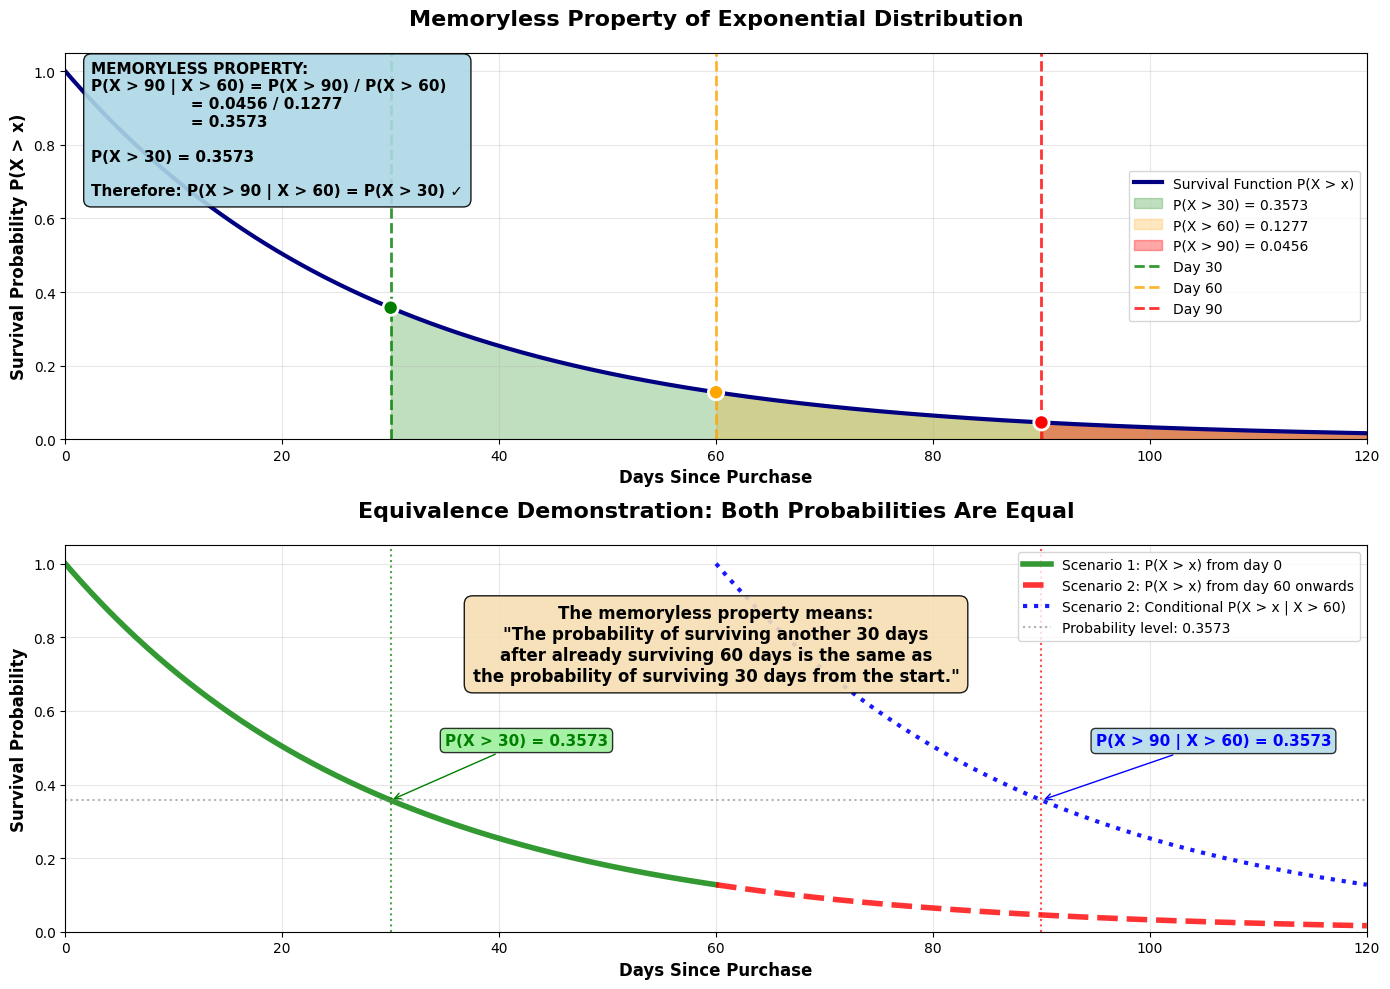

In [242]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
s = 60  # days already passed
t = 30  # additional days

# Calculating X > s + t and X > s
P_X_gt_90 = np.exp(-lambda_forall * (s + t))  # P(X > 90)
P_X_gt_60 = np.exp(-lambda_forall * s)        # P(X > 60)

# Conditional probability P(X > s + t | X > s)
P_gt_90_given_60 = P_X_gt_90 / P_X_gt_60

# Also directly compute P(X > 30)
P_X_gt_30 = np.exp(-lambda_forall * t)

# Display results
print(f"P(X > 90 | X > 60) = {P_gt_90_given_60:.4f}")
print(f"P(X > 30)          = {P_X_gt_30:.4f}")

# Generate data for visualization
x = np.linspace(0, 120, 1000)
survival_function = np.exp(-lambda_forall * x)

# Create the main visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# TOP PLOT: Complete survival function with memoryless property demonstration
ax1.plot(x, survival_function, label='Survival Function P(X > x)', 
         color='navy', linewidth=3)

# Highlight key regions
# Region 1: P(X > 30) - green shading
x_fill_30 = x[x >= 30]
sf_fill_30 = survival_function[x >= 30]
ax1.fill_between(x_fill_30, sf_fill_30, alpha=0.25, color='green', 
                 label=f'P(X > 30) = {P_X_gt_30:.4f}')

# Region 2: P(X > 60) - orange shading
x_fill_60 = x[x >= 60]
sf_fill_60 = survival_function[x >= 60]
ax1.fill_between(x_fill_60, sf_fill_60, alpha=0.25, color='orange', 
                 label=f'P(X > 60) = {P_X_gt_60:.4f}')

# Region 3: P(X > 90) - red shading
x_fill_90 = x[x >= 90]
sf_fill_90 = survival_function[x >= 90]
ax1.fill_between(x_fill_90, sf_fill_90, alpha=0.35, color='red', 
                 label=f'P(X > 90) = {P_X_gt_90:.4f}')

# Key vertical lines
ax1.axvline(30, color='green', linestyle='--', alpha=0.8, linewidth=2, label='Day 30')
ax1.axvline(60, color='orange', linestyle='--', alpha=0.8, linewidth=2, label='Day 60')
ax1.axvline(90, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Day 90')

# Mark key points
ax1.scatter([30, 60, 90], [P_X_gt_30, P_X_gt_60, P_X_gt_90], 
           color=['green', 'orange', 'red'], s=120, zorder=10, 
           edgecolors='white', linewidth=2)

# Memoryless property explanation box
memoryless_text = (f'MEMORYLESS PROPERTY:\n'
                  f'P(X > 90 | X > 60) = P(X > 90) / P(X > 60)\n'
                  f'                   = {P_X_gt_90:.4f} / {P_X_gt_60:.4f}\n'
                  f'                   = {P_gt_90_given_60:.4f}\n\n'
                  f'P(X > 30) = {P_X_gt_30:.4f}\n\n'
                  f'Therefore: P(X > 90 | X > 60) = P(X > 30) ✓')

ax1.text(0.02, 0.98, memoryless_text, transform=ax1.transAxes, 
         fontsize=11, weight='bold', verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.9))

ax1.set_title('Memoryless Property of Exponential Distribution', 
              fontsize=16, weight='bold', pad=20)
ax1.set_xlabel('Days Since Purchase', fontsize=12, weight='bold')
ax1.set_ylabel('Survival Probability P(X > x)', fontsize=12, weight='bold')
ax1.legend(loc='center right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.05)
ax1.set_xlim(0, 120)

# BOTTOM PLOT: Direct comparison of the two equivalent probabilities
# Create two scenarios side by side

# Scenario 1: Fresh start, what's P(X > 30)?
x1 = np.linspace(0, 60, 500)
sf1 = np.exp(-lambda_forall * x1)

# Scenario 2: Already survived 60 days, what's P(survive another 30)?
x2 = np.linspace(60, 120, 500)
sf2 = np.exp(-lambda_forall * x2)

# Plot both scenarios
ax2.plot(x1, sf1, color='green', linewidth=4, label='Scenario 1: P(X > x) from day 0', alpha=0.8)
ax2.plot(x2, sf2, color='red', linewidth=4, linestyle='--', 
         label='Scenario 2: P(X > x) from day 60 onwards', alpha=0.8)

# Normalize the second scenario to show conditional probability
sf2_conditional = sf2 / P_X_gt_60
ax2.plot(x2, sf2_conditional, color='blue', linewidth=3, linestyle=':', 
         label='Scenario 2: Conditional P(X > x | X > 60)', alpha=0.9)

# Mark the key comparison points
ax2.axvline(30, color='green', linestyle=':', alpha=0.7)
ax2.axvline(90, color='red', linestyle=':', alpha=0.7)
ax2.axhline(P_X_gt_30, color='gray', linestyle=':', alpha=0.6, 
            label=f'Probability level: {P_X_gt_30:.4f}')

# Add comparison annotations
ax2.annotate(f'P(X > 30) = {P_X_gt_30:.4f}', 
             xy=(30, P_X_gt_30), xytext=(35, P_X_gt_30 + 0.15),
             fontsize=11, color='green', weight='bold',
             arrowprops=dict(arrowstyle='->', color='green'),
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))

ax2.annotate(f'P(X > 90 | X > 60) = {P_gt_90_given_60:.4f}', 
             xy=(90, P_gt_90_given_60), xytext=(95, P_gt_90_given_60 + 0.15),
             fontsize=11, color='blue', weight='bold',
             arrowprops=dict(arrowstyle='->', color='blue'),
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))

# Explanation text
explanation = ('The memoryless property means:\n'
               '"The probability of surviving another 30 days\n'
               'after already surviving 60 days is the same as\n'
               'the probability of surviving 30 days from the start."')

ax2.text(0.5, 0.65, explanation, transform=ax2.transAxes, 
         fontsize=12, weight='bold', horizontalalignment='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.9))

ax2.set_title('Equivalence Demonstration: Both Probabilities Are Equal', 
              fontsize=16, weight='bold', pad=20)
ax2.set_xlabel('Days Since Purchase', fontsize=12, weight='bold')
ax2.set_ylabel('Survival Probability', fontsize=12, weight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.05)
ax2.set_xlim(0, 120)

plt.tight_layout()
plt.savefig('memoryless_property_rewritten.png', dpi=300, bbox_inches='tight')
plt.show()

